P10.1 Competition for a community detection method [5P]

• You work in groups of one or two students.

• Each such group implements the selected community detection method.

• We will test every implementation with benchmark.

In [7]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from copy import deepcopy
rng = np.random.default_rng()

In [8]:
def clean_subsets(results_dict, close_threshold):
    clusters = []
    for node, neigh in results_dict.items():
        dist1 = [key for key, val in neigh.items() if val <= close_threshold]
        for clust in clusters:
            if node in clust:
                clust.update(dist1)
                break
        else:
            new_set = set([node]+dist1)
            if len(new_set)>1:
                clusters.append(new_set)
    clusters2 = deepcopy(clusters)
    for first_set in clusters:
        for second_set in clusters:
            if first_set.issubset(second_set) and not first_set.issuperset(second_set):
                if first_set in clusters2:
                    clusters2.remove(first_set)
    return clusters2

def cluster_func(G, max_steps_walk = 20, n_walks = 100, close_threshold = 1, K_clusters=None):
    results_dict = {}
    for node in G.nodes():
        neighbors_dict = {}
        for node_neighbor in G.neighbors(node):
            neighbour_neighbours = list(G.neighbors(node_neighbor))
            neighbour_neighbours.remove(node)
            if len(neighbour_neighbours) == 0:
                continue
            walks = []
            for i in range(n_walks):
                curr_step = rng.choice(neighbour_neighbours)
                for j in range(1, max_steps_walk):
                    neigh_neigh_neigh = list(G.neighbors(curr_step))
                    if curr_step == node_neighbor:
                        neigh_neigh_neigh.remove(node)
                    curr_step = rng.choice(neigh_neigh_neigh)
                    if curr_step == node:
                        break
                if j == max_steps_walk-1 and curr_step != node:
                    continue
                walks.append(j)
            if len(walks)>0:
                neighbors_dict[node_neighbor] = np.min(walks)
        results_dict[node] = neighbors_dict
    clusters2 = clean_subsets(results_dict, close_threshold)
    if K_clusters is not None:
        if len(clusters2) != K_clusters:
            clusterss = [clean_subsets(results_dict, i) for i in range(4) if i!=close_threshold]
            lengths_diff = [K_clusters-len(x) for x in clusterss]
            clusters2 = clusterss[np.argmin(np.abs(lengths_diff))]
    not_clustered_id = len(clusters2)*3
    cluster_dict = {node:not_clustered_id for node in G.nodes()}
    for i, clust in enumerate(clusters2):
        for val in clust:
            cluster_dict[val] = i
    for node, cluster_id in cluster_dict.items():
        if cluster_id == not_clustered_id:
            new_random = rng.choice([cluster_dict[n] for n in G.neighbors(node)])
            if new_random == not_clustered_id:
                new_random = rng.integers(0, not_clustered_id//3)
            cluster_dict[node] = new_random
    return cluster_dict

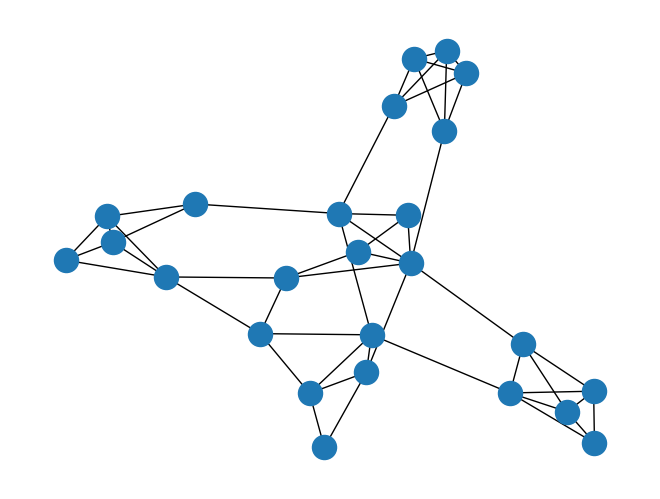

In [9]:
G = nx.relaxed_caveman_graph(5,5, 0.2)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos)

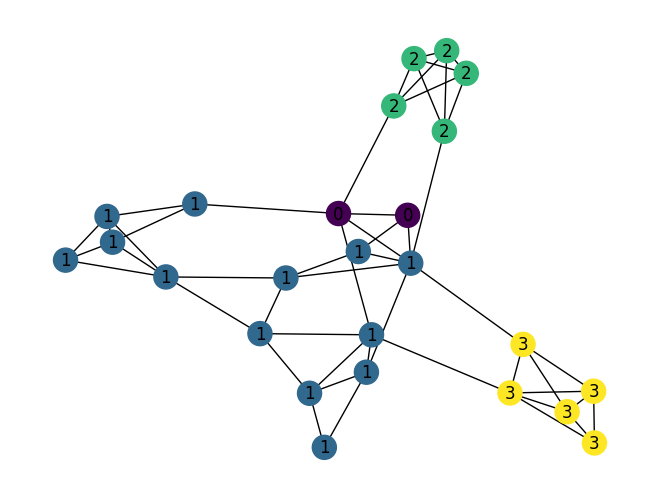

In [10]:
cluster_dict = cluster_func(G)
nx.draw(G, pos=pos, node_color=list(cluster_dict.values()),  labels=cluster_dict)

# Not known k

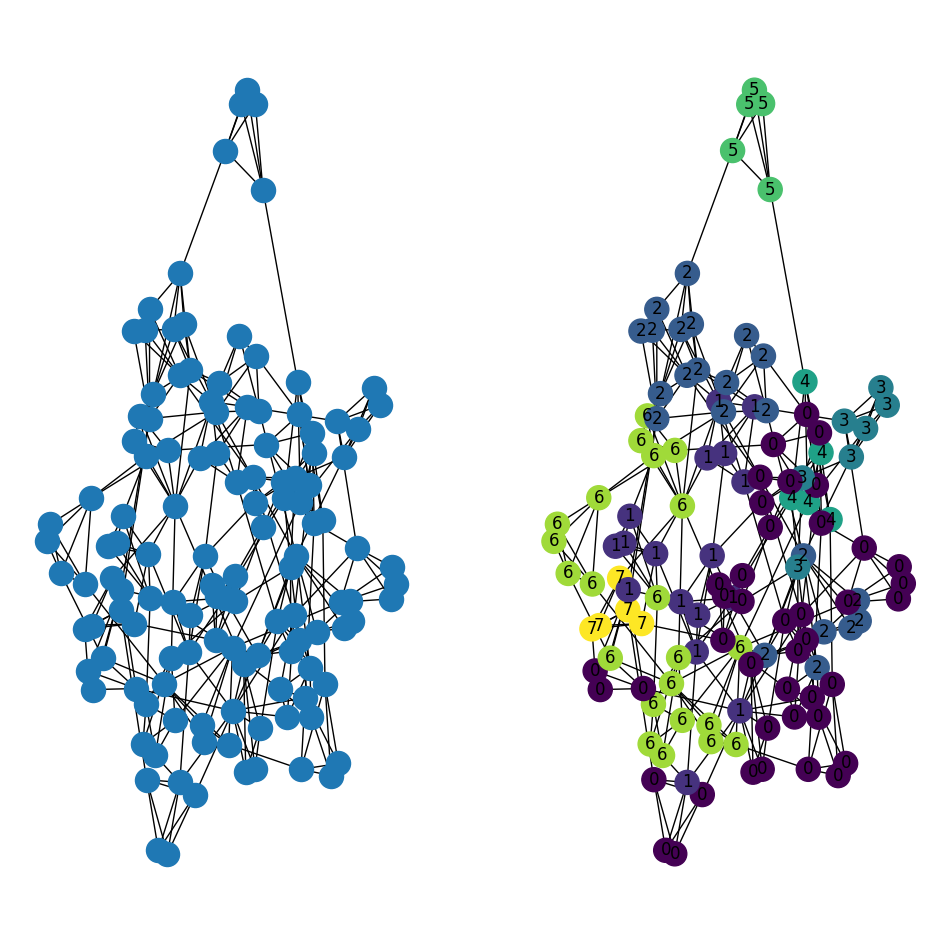

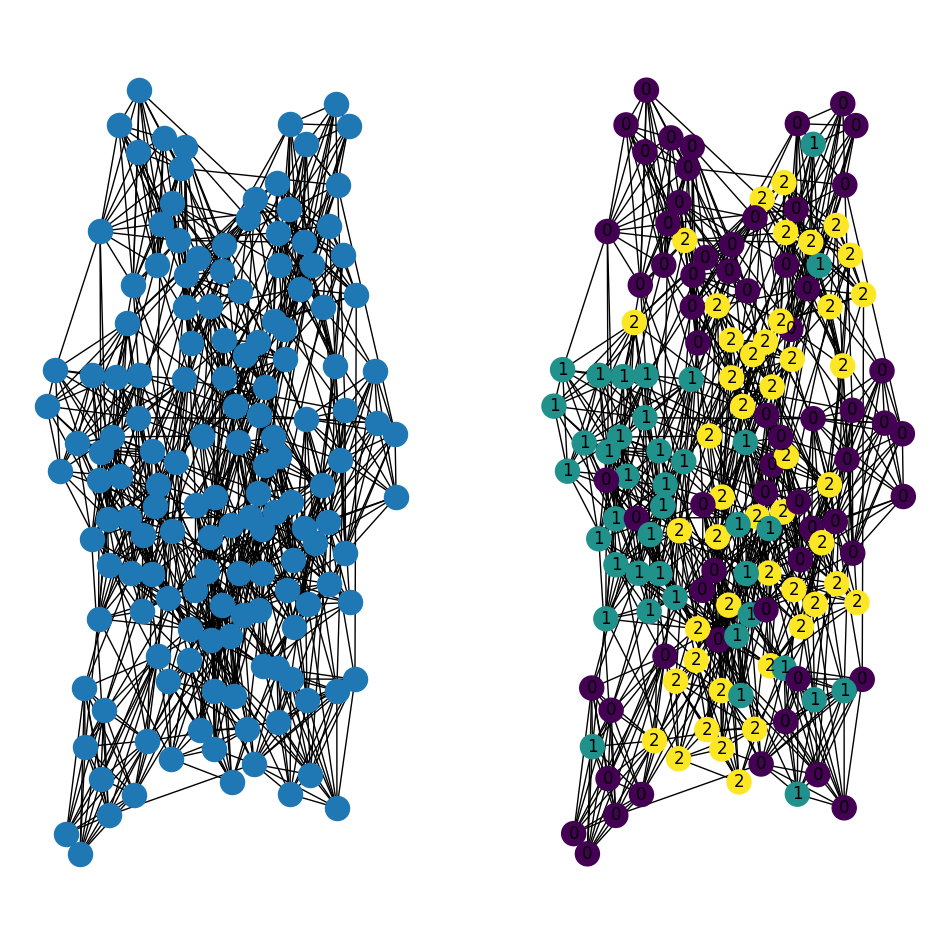

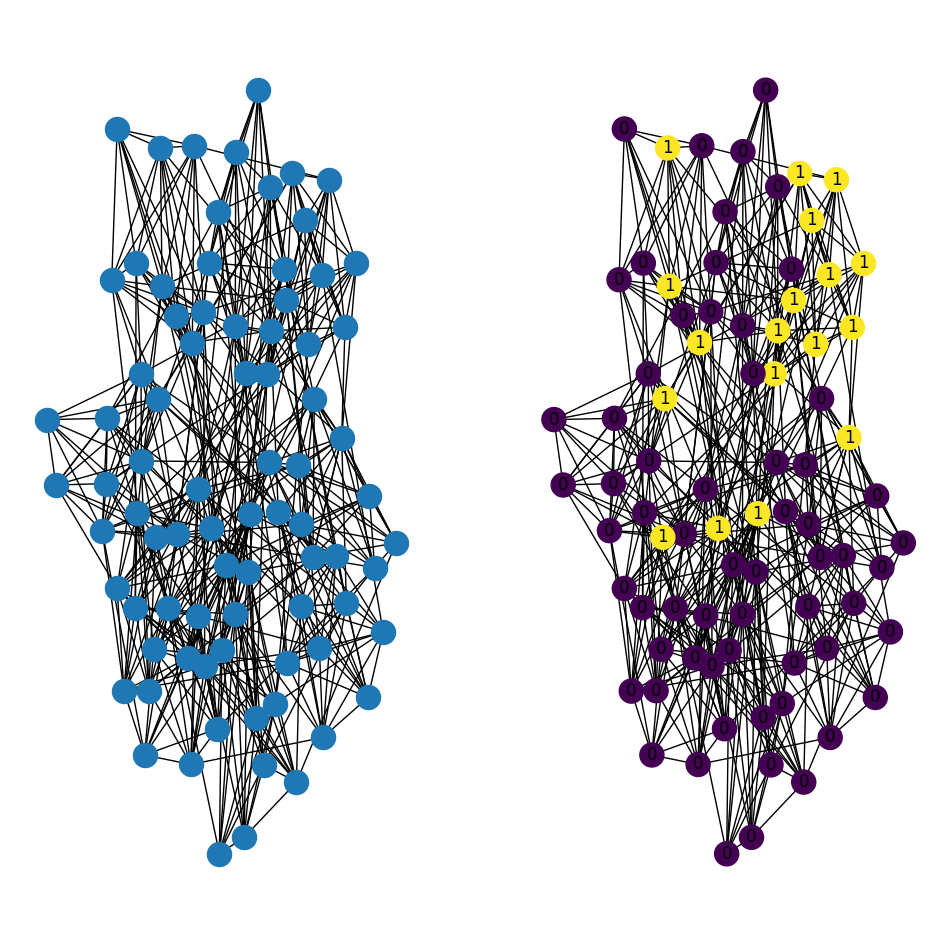

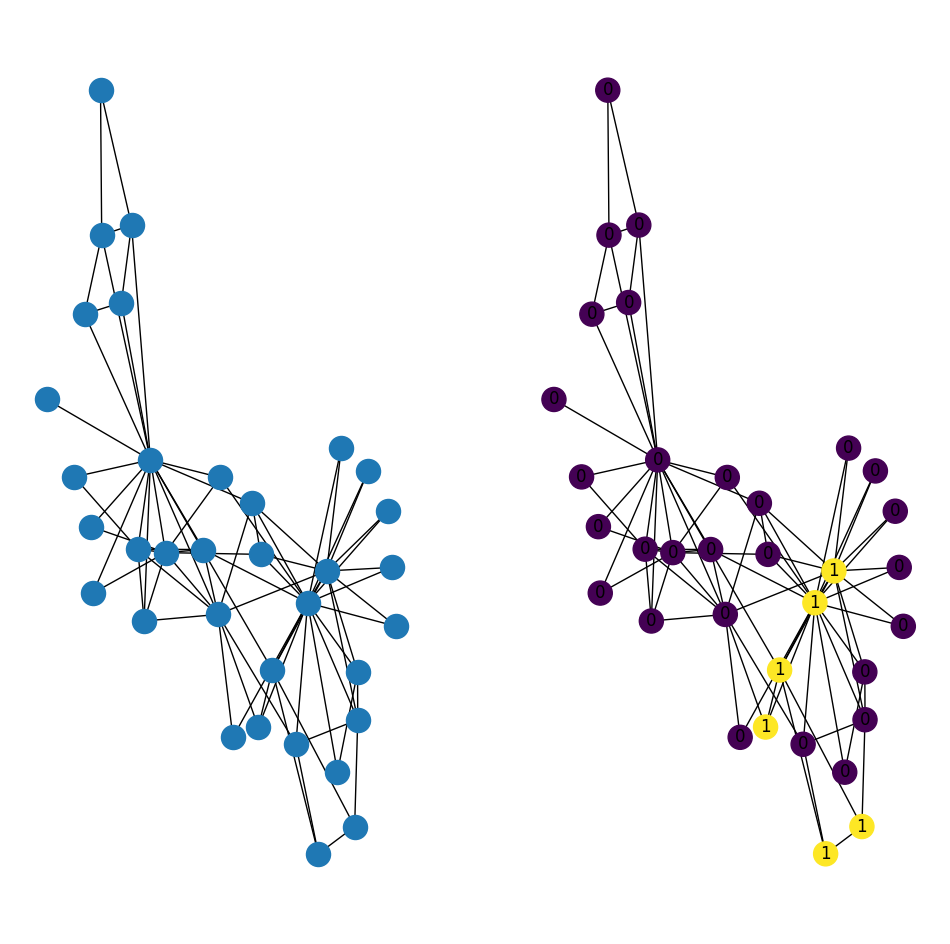

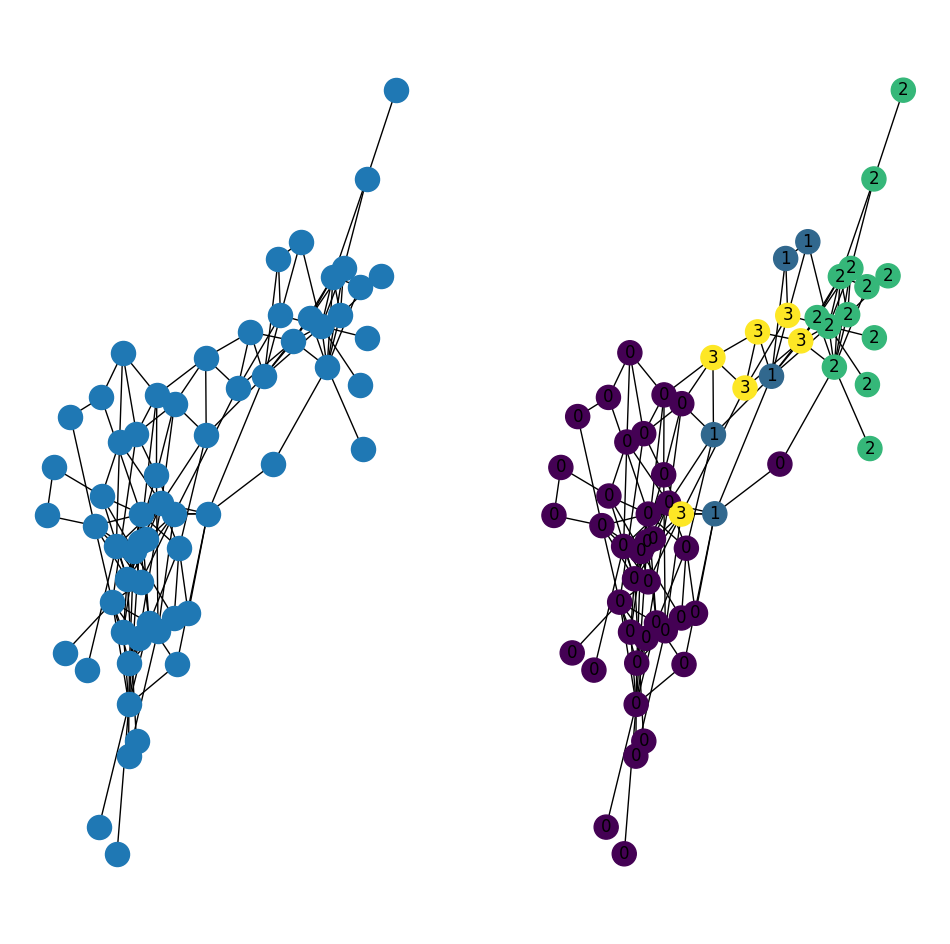

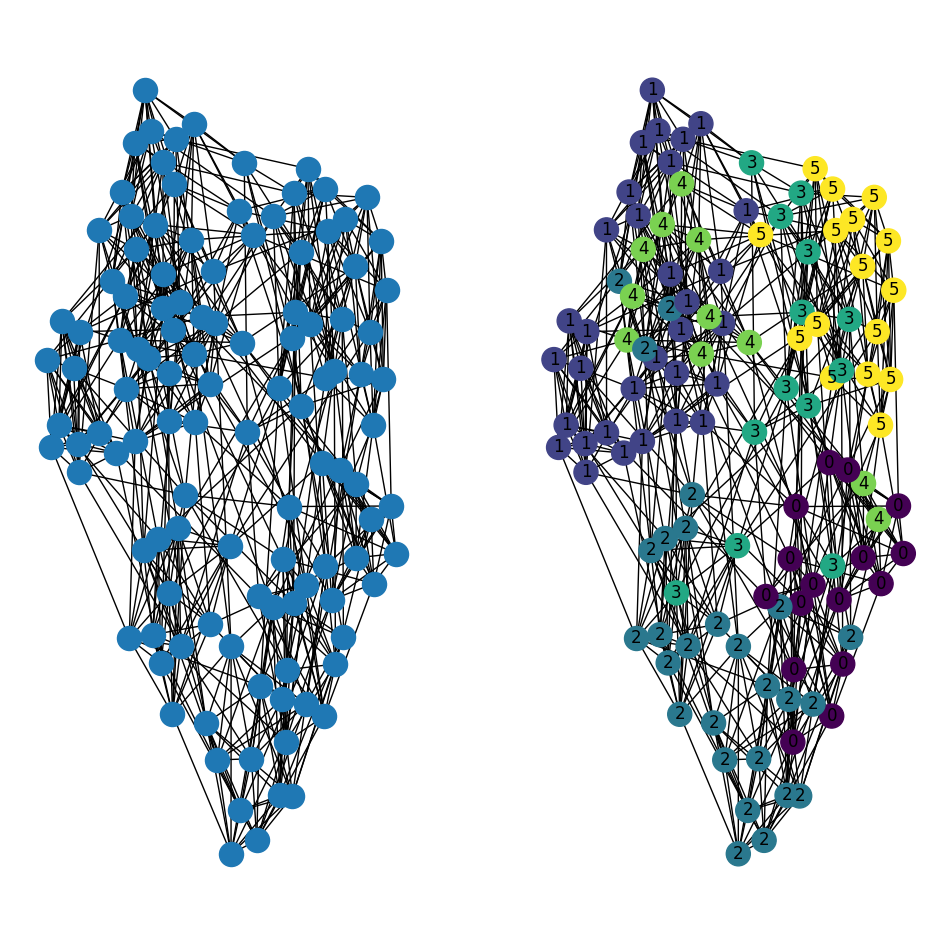

In [15]:
with open('description.txt', 'w+') as f:
    f.write('Mateusz Sperkowski\n')
    f.write('https://github.com/MattS0000/SNaRS_comp_2023Z')
    for file, params in zip(['D1-UNC.csv', 'D2-UNC.csv', 'D3-UNC.csv', 'D1-K=2.csv', 'D2-K=7.csv', 'D3-K=12.csv'], [(500, 3, 20, None), (500, 1, 10, None), (500, 1, 20, None), (1000, 1, 20, 2), (1000, 1, 10, 7), (500, 2, 20, 12)]):
        adj = pd.read_csv('./competition/'+file, header=None)
        G = nx.from_pandas_adjacency(adj)
        pos = nx.spring_layout(G)
        fig, ax = plt.subplots(ncols=2, figsize=(12,12))
        nx.draw(G, pos=pos, ax=ax[0])
        st = time.process_time()
        cluster_dict = cluster_func(G, n_walks = params[0]*2, close_threshold=params[1], max_steps_walk=params[2], K_clusters=params[3])
        et = time.process_time()
        f.write(f"\n{file},{et-st}")
        vals = list(cluster_dict.values())
        mapping = {x:y for x,y in zip(pd.unique(vals), list(range(len(vals))))}
        with open(file, 'w+') as f_csv:
            for node, cluster_id in cluster_dict.items():
                f_csv.write(f"{node+1},{mapping[cluster_id]+1}\n")
        nx.draw(G, pos=pos, node_color=list(cluster_dict.values()),  labels=cluster_dict, ax=ax[1])